# What is a classification problem

* Binary classification: Target can be one of two options, e.g. yes or no	Predict whether or not someone has heart disease based on their health parameters.

* Multi-class classification: Target can be one of more than two options	Decide whether a photo is of food, a person or a dog.

* Multi-label classification: Target can be assigned more than one option	Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy).

# 0. Architecture of a classification neural network

 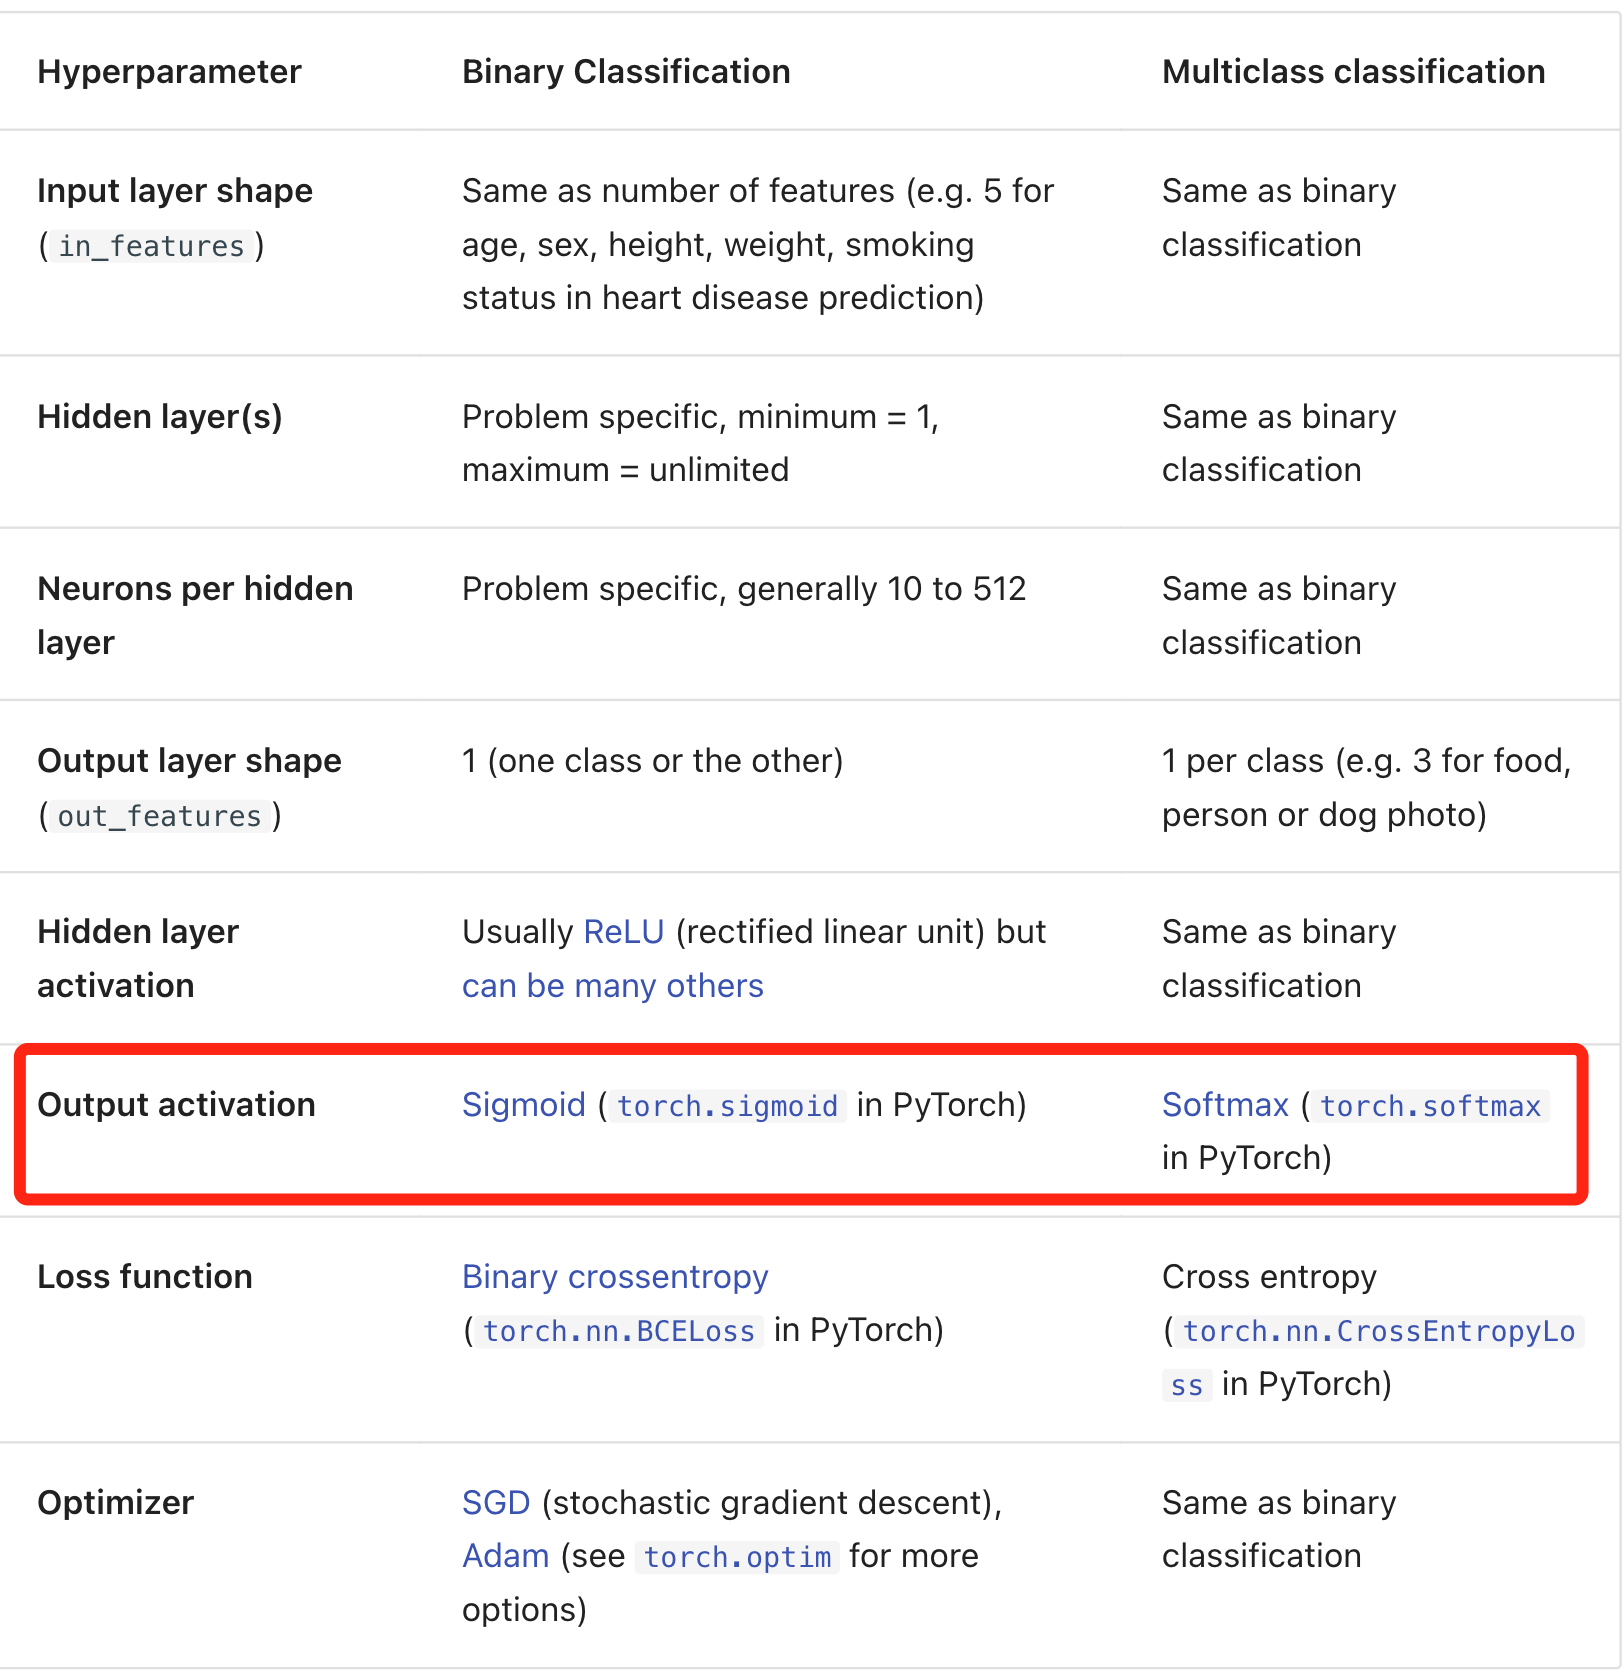

# 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({'x1':X[:,0],'x2':X[:,1],'label':y})

circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

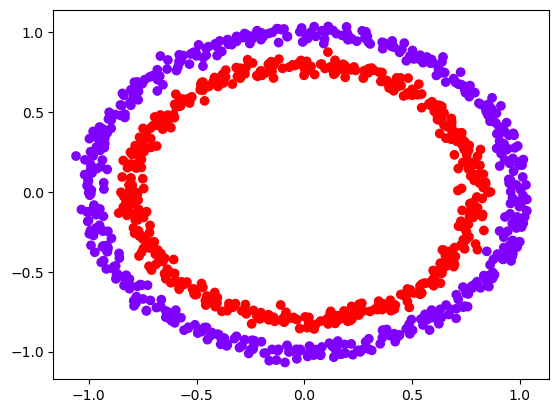

In [5]:
import matplotlib.pyplot as plt

plt.scatter(circles['x1'],circles['x2'],c=circles['label'],cmap='rainbow')

## 1.1 Input and output shapes

One of the most common errors in deep learning is shape errors.

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# 2. Building a model

In [14]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [15]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
torch.__version__

'2.5.1'

In [16]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.6994],
        [0.5871],
        [0.9508],
        [0.6284],
        [0.8824],
        [0.8143],
        [0.5522],
        [0.6052],
        [0.9533],
        [0.5788]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer

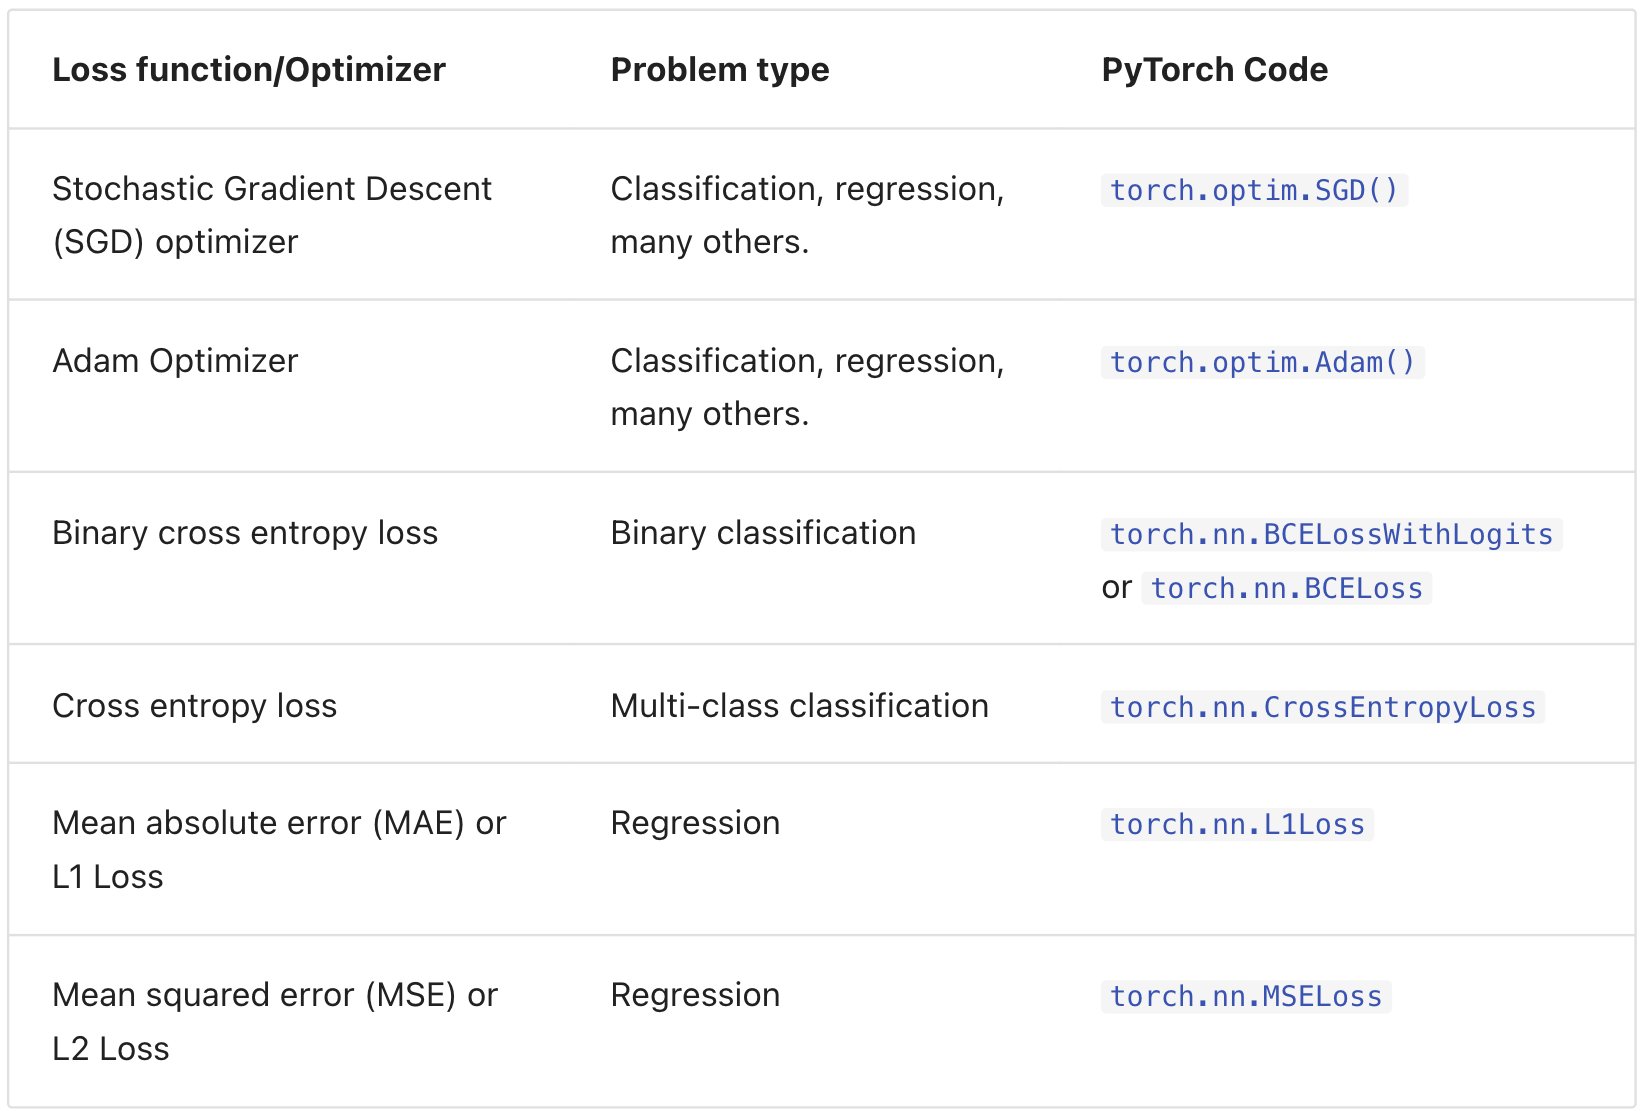

In [17]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 3. Train model

1. Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).

2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

5. Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

## 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [19]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.6994],
        [0.5871],
        [0.9508],
        [0.6284],
        [0.8824]], device='mps:0', grad_fn=<SliceBackward0>)

In [20]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6681],
        [0.6427],
        [0.7213],
        [0.6521],
        [0.7073]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [24]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
print(y_preds.squeeze())
# print(y_preds)

tensor([True, True, True, True, True], device='mps:0')
tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)


In [29]:
y_test[:5], y_preds.squeeze()[:5]

(tensor([1., 0., 1., 0., 1.]),
 tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SliceBackward0>))

In [31]:
len(y_test), len(y_preds.squeeze())

(200, 5)

In [34]:
accuracy_fn(y_test.to(device)[:5], y_preds.squeeze().to(device))

60.0

## 3.2 Building a training and testing loop

In [35]:
%time
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training mode
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing mode
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

CPU times: user 3 μs, sys: 3 μs, total: 6 μs
Wall time: 14.1 μs
Epoch: 0 | Loss: 0.77338, Accuracy: 50.00% | Test loss: 0.75386, Test acc: 50.00%
Epoch: 10 | Loss: 0.71545, Accuracy: 50.00% | Test loss: 0.70686, Test acc: 50.00%
Epoch: 20 | Loss: 0.69995, Accuracy: 50.00% | Test loss: 0.69502, Test acc: 50.00%
Epoch: 30 | Loss: 0.69571, Accuracy: 57.88% | Test loss: 0.69222, Test acc: 61.00%
Epoch: 40 | Loss: 0.69450, Accuracy: 51.88% | Test loss: 0.69170, Test acc: 53.00%
Epoch: 50 | Loss: 0.69409, Accuracy: 50.00% | Test loss: 0.69170, Test acc: 53.00%
Epoch: 60 | Loss: 0.69391, Accuracy: 49.62% | Test loss: 0.69181, Test acc: 53.50%
Epoch: 70 | Loss: 0.69380, Accuracy: 49.00% | Test loss: 0.69193, Test acc: 54.50%
Epoch: 80 | Loss: 0.69371, Accuracy: 48.62% | Test loss: 0.69204, Test acc: 53.50%
Epoch: 90 | Loss: 0.69364, Accuracy: 49.00% | Test loss: 0.69214, Test acc: 52.50%


The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

# 4. Make predictions and evaluate the model

In [37]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


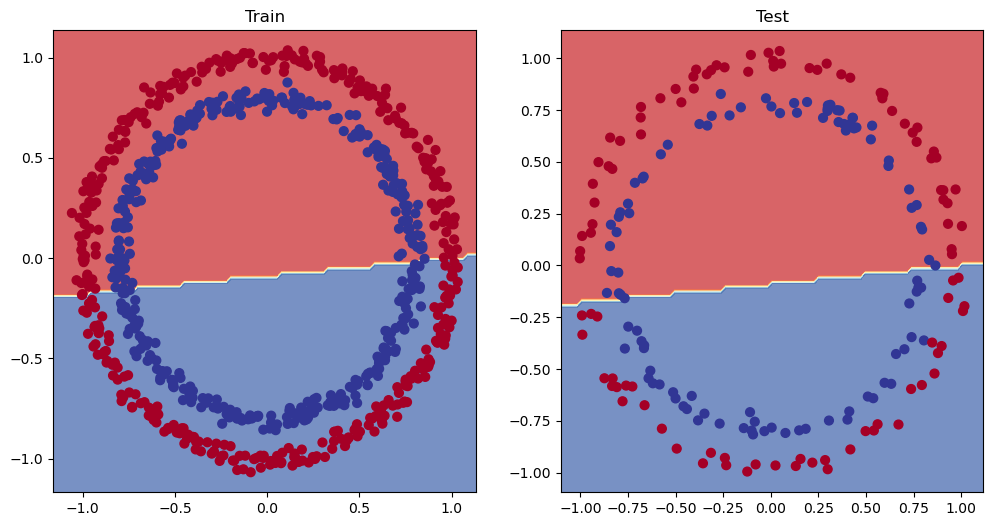

In [38]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. Improving a model (from a model perspective)

In [39]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [42]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


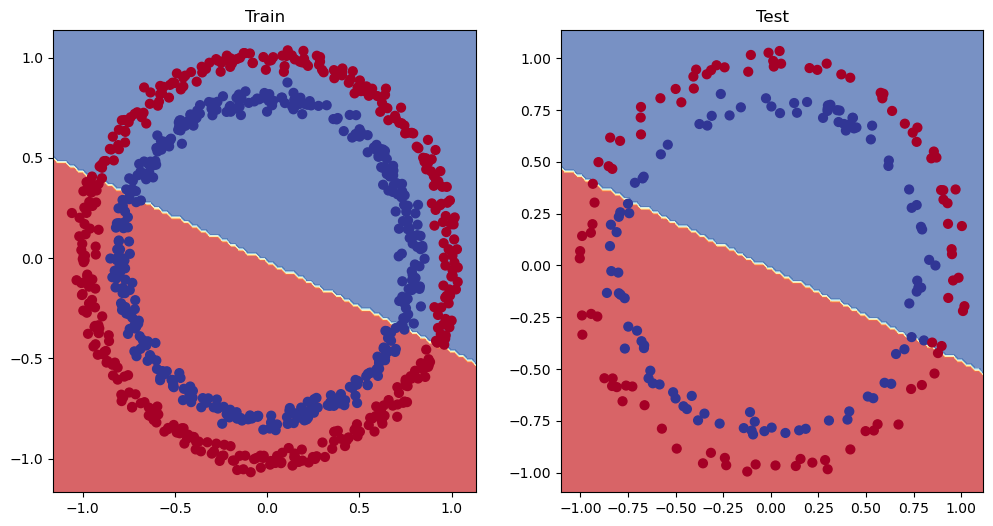

In [43]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing data to see if our model can model a straight line

In [56]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [57]:
train_split = int(0.8 * len(X_regression))
X_train = X_regression[:train_split]
X_test = X_regression[train_split:]
y_train = y_regression[:train_split]
y_test = y_regression[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(80, 20, 80, 20)

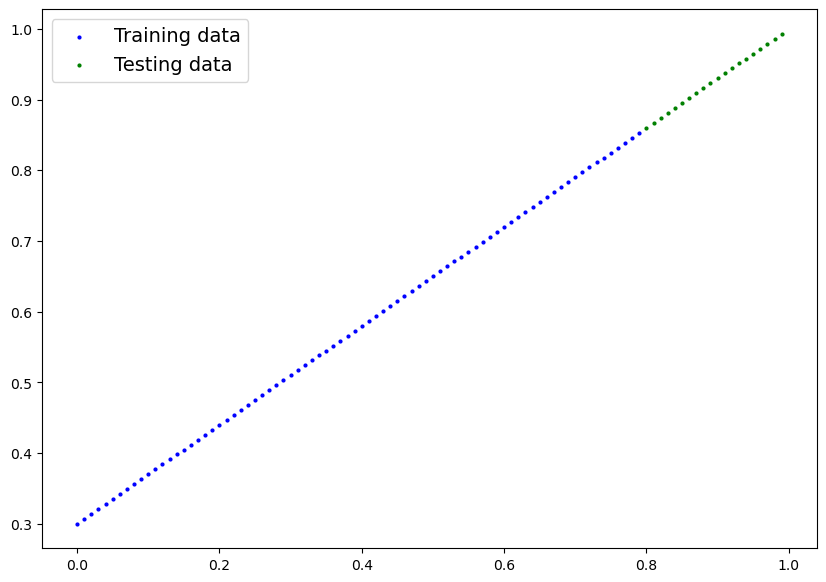

In [58]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test)

## 5.2 Adjusting model_1 to fit a straight line

In [63]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [64]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.1)

In [65]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train() 

    y_pred = model_2(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test).squeeze()
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test loss: 0.04769
Epoch: 200 | Loss: 0.07376 | Test loss: 0.04752
Epoch: 300 | Loss: 0.06745 | Test loss: 0.04291
Epoch: 400 | Loss: 0.06107 | Test loss: 0.04527
Epoch: 500 | Loss: 0.05698 | Test loss: 0.04340
Epoch: 600 | Loss: 0.04857 | Test loss: 0.04428
Epoch: 700 | Loss: 0.06109 | Test loss: 0.04527
Epoch: 800 | Loss: 0.05599 | Test loss: 0.04504
Epoch: 900 | Loss: 0.05571 | Test loss: 0.04298


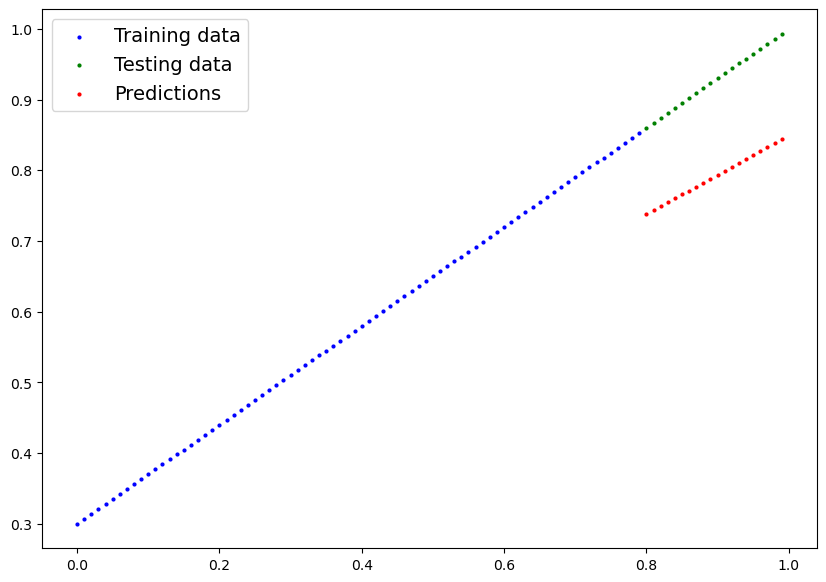

In [70]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train.cpu(),
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu(),
                 predictions=y_preds.cpu());

# 6.The missing piece: non-linearity

## 6.1 Recreating non-linear data (red and blue circles)

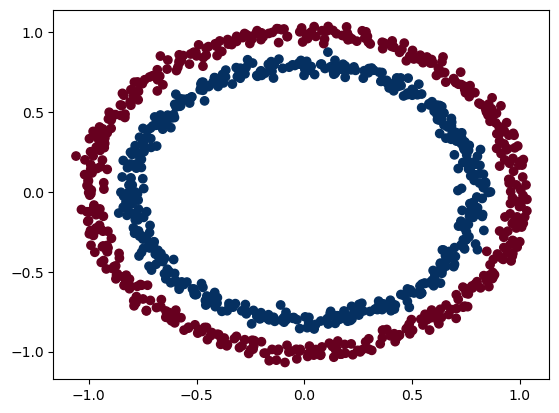

In [74]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [75]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [76]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [77]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## 6.3 Training a model with non-linearity

In [78]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


## 6.4 Evaluating a model trained with non-linear activation functions

In [79]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

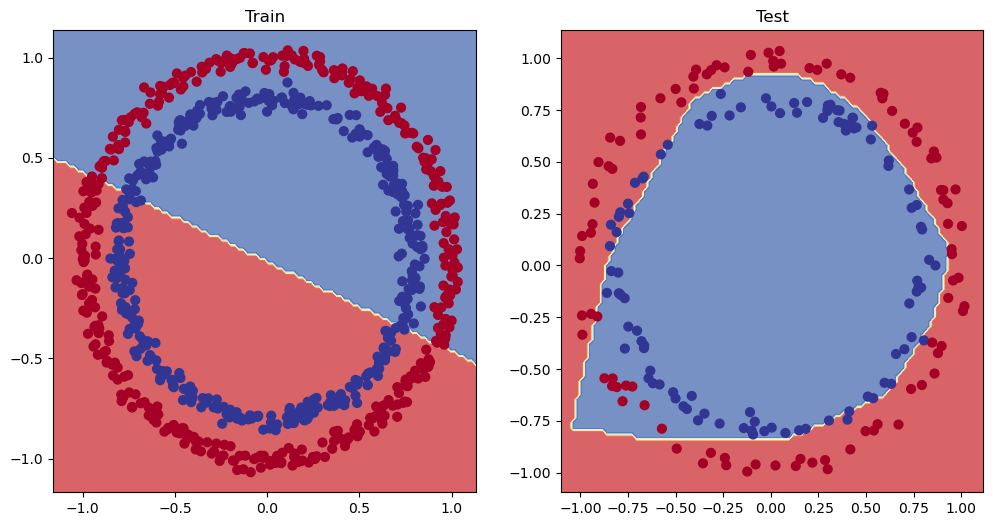

In [80]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# 7.Replicating non-linear activation functions¶

In [81]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

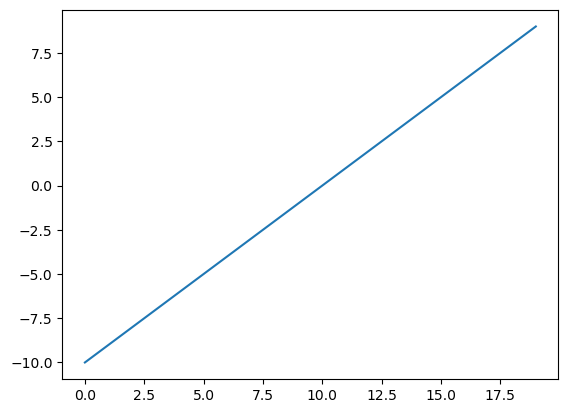

In [82]:
# Visualize the toy tensor
plt.plot(A);

In [83]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

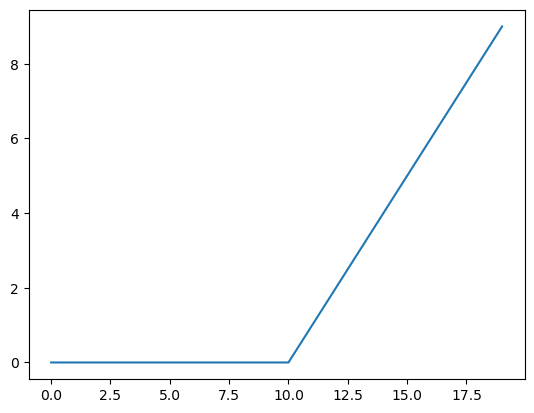

In [84]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [85]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

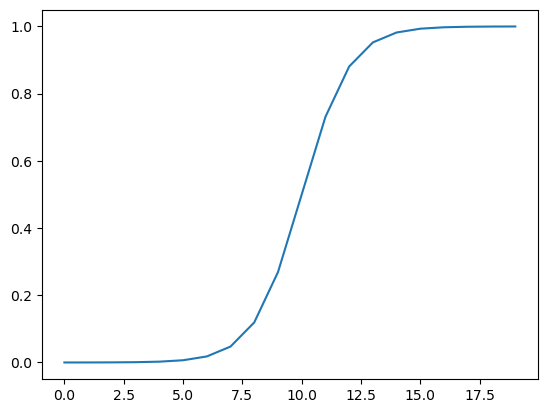

In [86]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

# 8.Putting things together by building a multi-class PyTorch model

## 8.1 Creating multi-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


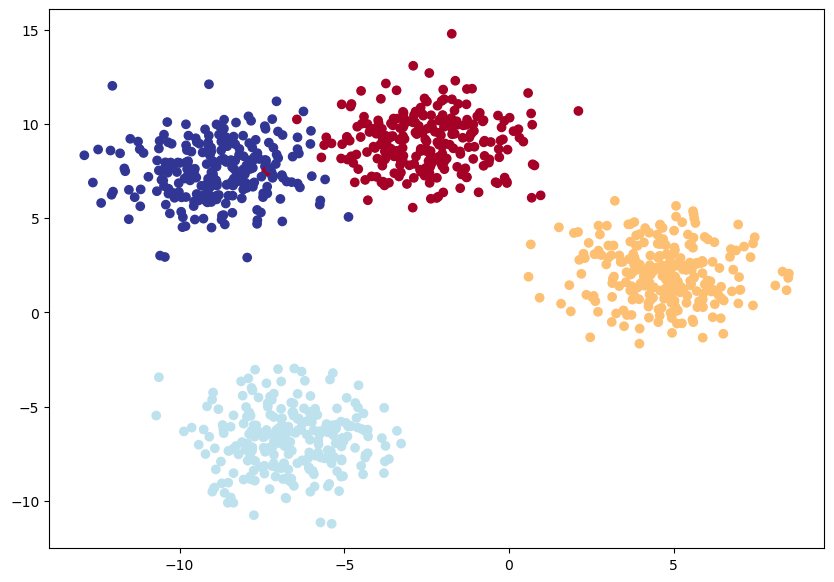

In [87]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 8.2 Building a multi-class classification model in PyTorch

In [89]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [90]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [91]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

## 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [92]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [93]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [94]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [95]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, device='mps:0', grad_fn=<SumBackward0>)

In [96]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='mps:0')


## 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [97]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [98]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7643],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5919, -18.5990,  25.5310,  17.5800],
        [  7.3142,   0.7197, -11.2018,  -1.2011]], device='mps:0')

In [99]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Test accuracy: 99.5%


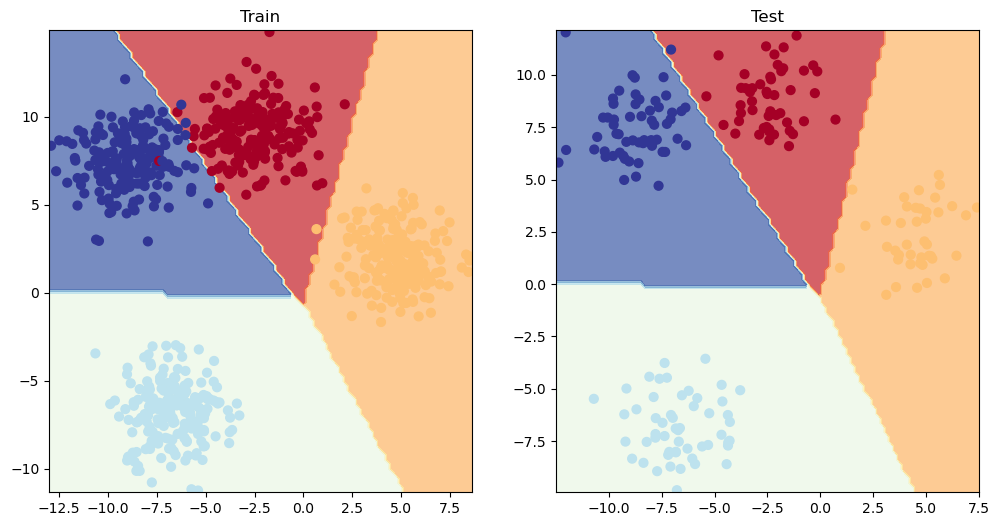

In [100]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)